# PROJECT PROPOSAL GROUP 26

## Impact of Cholesterol Levels and Age on Heart Disease

### Introduction

Heart disease is one of the leading causes of death around the globe (Fillmore et al., 2014). Several factors can increase the likelihood of developing heart diseases, such as age, high blood pressure, high cholesterol levels, obesity, diabetes, and family history (Dahlöf, 2010).

In this project, we aim to investigate the impact of age and cholesterol levels on the chances of developing heart disease. Therefore, the main question we will try to answer with our project is: "Do age and cholesterol levels affect the likelihood of developing heart disease?" To do this, we will build a K-nearest neighbors classification model to predict diagnosis using age and cholesterol level predictor variables.

The dataset we are using is collected by the University of California, Irvine, and contains data on 303 individuals and 14 different variables. Demographic and clinical measurements include age, sex, chest pain type, resting blood pressure, and serum cholesterol in mg/dL, among others.

### Data Analysis

In [112]:
#Load this before continuing
library(tidyverse)
library(repr)
library(tidymodels)


In [113]:
#Reading data into R

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cleveland_heart <- read_csv(url)
head(cleveland_heart)


New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


63.0,1.0...2,1.0...3,145.0,233.0,1.0...6,2.0,150.0,0.0...9,2.3,3.0,0.0...12,6.0,0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3


**Below we change the names of the columns to the variable names given in the dataset.**

In [114]:
#Change column names to given varaibles from dataset

colnames(cleveland_heart) <- c("age", "sex", "chest_pain", "resting_blood_pressure", "cholesterol_level", "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", "exercise_induced_angina", "oldpeak", "slope", "major_vessels_colored", "thal", "diagnosis")
head(cleveland_heart)


age,sex,chest_pain,resting_blood_pressure,cholesterol_level,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,major_vessels_colored,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3


In [115]:
#Selecting our relevant variables into a tidy format

heart_clean <- cleveland_heart |>
select(age, cholesterol_level, diagnosis)
head(heart_clean)


age,cholesterol_level,diagnosis
<dbl>,<dbl>,<dbl>
67,286,2
67,229,1
37,250,0
41,204,0
56,236,0
62,268,3


**The diagnosis variable contains the numbers 0-4, with 0 indicating no heart diagnosis and 1-4 indicating different types of heart diagnoses. Here we mutate the diagnosis variable such that it will read FALSE when no heart diagnosis exists and TRUE when a heart diagnosis does exist (regardless of what type of diagnosis it is).**

In [116]:
#Change diagnosis to FALSE for no heart diagnosis and TRUE for any heart diagnosis
heart_diagnosis <- heart_clean |>
mutate(Diagnosis = (diagnosis != 0)) |>
mutate("Diagnosis" = as_factor(Diagnosis))
head(heart_diagnosis)


age,cholesterol_level,diagnosis,Diagnosis
<dbl>,<dbl>,<dbl>,<fct>
67,286,2,TRUE
67,229,1,TRUE
37,250,0,FALSE
41,204,0,FALSE
56,236,0,FALSE
62,268,3,TRUE


In [117]:
#Now choose the required variables

heart_data <- heart_diagnosis |>
select(-diagnosis)
head(heart_data)


age,cholesterol_level,Diagnosis
<dbl>,<dbl>,<fct>
67,286,TRUE
67,229,TRUE
37,250,FALSE
41,204,FALSE
56,236,FALSE
62,268,TRUE


In [118]:
#Split data into training and testing

set.seed(1234)

heart_data_split <- initial_split(heart_data, prop = 0.75, strata = Diagnosis)
heart_data_train <- training(heart_data_split)
heart_data_test <- testing(heart_data_split)


**Summary table below shows that the data will be sufficient to create a classification model.** 

In [119]:
#Creating data summary table of training data

heart_table <- heart_data_train |>
group_by(Diagnosis) |>
summarize(num_obs = n(),
mean_age = mean(age, na.rm = TRUE),
mean_cholesterol = mean(cholesterol_level, na.rm = TRUE),
num_missing = sum((is.na(age)) + sum(is.na(cholesterol_level))))
heart_table


Diagnosis,num_obs,mean_age,mean_cholesterol,num_missing
<fct>,<int>,<dbl>,<dbl>,<int>
FALSE,122,52.70492,240.7295,0
TRUE,104,56.94231,254.7981,0


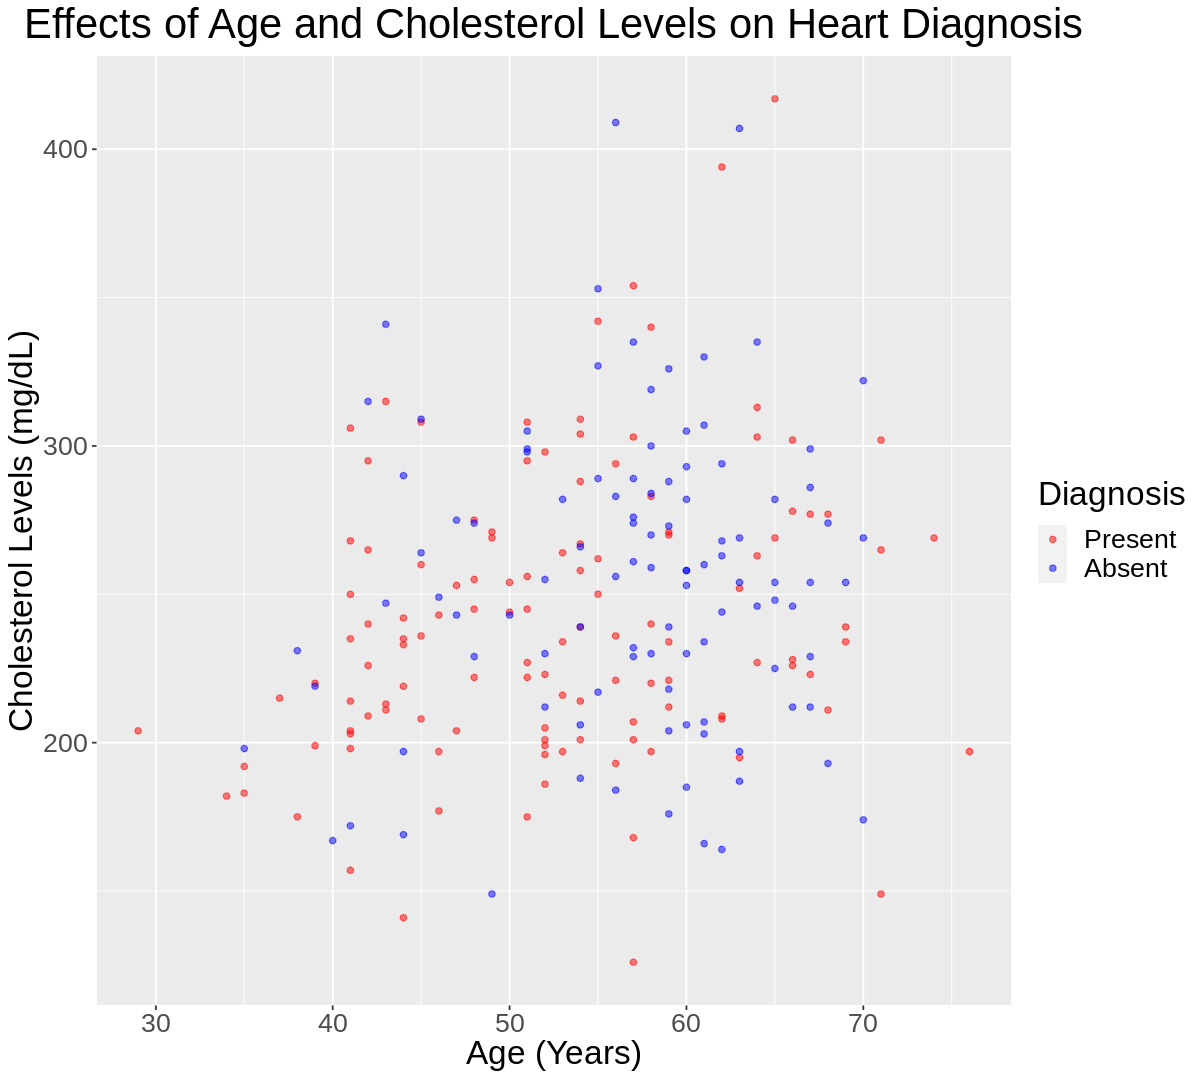

In [120]:
#Creating a plot to visualize effects of age and cholesterol levels

options(repr.plot.width = 10, repr.plot.height = 9)

heart_data_plot <- heart_data_train |>
ggplot(aes(x = age, y = cholesterol_level, color = Diagnosis)) +
geom_point(alpha = 0.5) +
labs(title = "Effects of Age and Cholesterol Levels on Heart Diagnosis", x = "Age (Years)", y = "Cholesterol Levels (mg/dL)", color = "Diagnosis") +
scale_color_manual(labels = c("Present", "Absent"), values = c("red", "blue")) +
theme(plot.title = element_text(hjust = 0.5, size = 25),
axis.title.x = element_text(size = 20),
axis.title.y = element_text(size = 20),
text = element_text(size = 20))
heart_data_plot


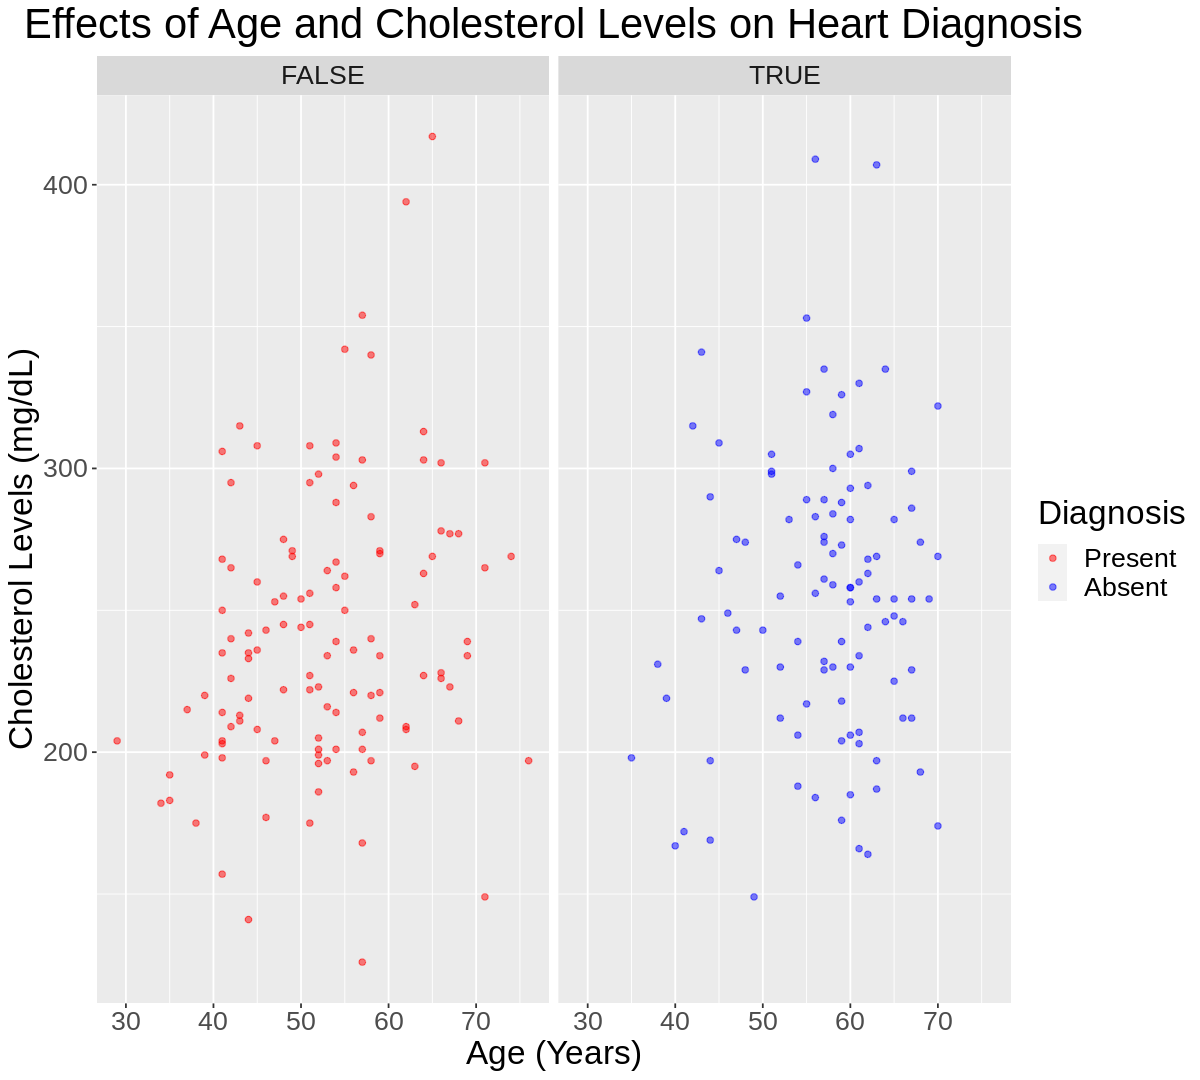

In [121]:
#Seperate the patient populations into ones with or without a diagnosis

heart_plot_wrapped <- heart_data_plot +
facet_wrap(~Diagnosis)
heart_plot_wrapped


### Methods

We will use the variables age and cholesterol levels and observe their effects on diagnosing a heart condition to determine if there is a correlation between the two. We will split the data into training and testing data to run our classification data analysis. We will then test different k-values and plot them against their accuracy to determine the best k-value for the classification. We will then build a classification model using the training dataset and the best k-value. Then we can test the model using the testing data and compare the results of the model to that of the testing data. We can then determine the model's accuracy and create a confusion matrix to understand how effective our model is at predicting the diagnosis of a heart condition. A visualization we can use to visualize our results would be a line plot, as it can show the change in the number of diagnoses as age and cholesterol levels change.

### Expected Outcomes and Significance

Expected findings: We expect to find positive relationships between age and heart disease, as well as cholesterol and heart disease. With increasing age and increasing cholesterol, we expect an increased likelihood of heart disease.

Impact: Our findings can help understand some contributing factors of heart disease. For example, understanding the impact of cholesterol on the risk of heart disease can help prevent it by modifying diet and health, etc.

Future Questions: If cholesterol impacts the risk of heart disease, how can we work on controlling its levels (i.e. diet, exercise)? If age impacts the risk of heart disease, what are some other ways to lower the risk in the elderly population?

### References

Dahlöf, B. (2010). Cardiovascular disease risk factors: Epidemiology and risk assessment. *The American Journal of Cardiology,    105*(1). https://doi.org/10.1016/j.amjcard.2009.10.007 

Fillmore, N., Mori, J., &amp; Lopaschuk, G. D. (2014). Mitochondrial fatty acid oxidation alterations in 
    heart failure, ischaemic heart disease and diabetic cardiomyopathy. *British Journal of Pharmacology,    171*(8), 2080–2090. https://doi.org/10.1111/bph.12475 